In [1]:
from pathlib import Path

from arcgis.features import GeoAccessor
from arcgis.geoenrichment._business_analyst import BusinessAnalyst
import arcpy
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dir_prj = Path.cwd().parent
dir_data = dir_prj/'data'
dir_int = dir_data/'interim'
gdb_int = dir_int/'interim.gdb'

arcpy.env.overwriteOutput = True

In [3]:
aoi_fc = gdb_int/'thurston_county'
id_col = 'FIPS'
kmeans_fc = gdb_int/f'{aoi_fc.stem}_kmeans'

enrich_fc = gdb_int/'block_groups_enrich'

In [4]:
fld_lst = [f.name.lower() for f in arcpy.ListFields(str(enrch_fc))]

In [5]:
ev = BusinessAnalyst('local').get_country('usa').enrich_variables

In [10]:
analysis_vars = list(ev[ev.enrich_field_name.str.lower().isin(fld_lst)].drop_duplicates('name').enrich_field_name)

print(f'{len(analysis_vars):,}')

3,572


In [11]:
in_df = pd.DataFrame([r for r in arcpy.da.SearchCursor(str(enrch_fc), analysis_vars)], columns=analysis_vars)
# in_df.fillna(0, inplace=True)
in_df.info()
in_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2478 entries, 0 to 2477
Columns: 3572 entries, AgeDependency_CHILD_CY to yearmovedin_RELOWNER
dtypes: float64(3572)
memory usage: 67.5 MB


,AgeDependency_CHILD_CY,AgeDependency_WORKAGE_CY,AgeDependency_SENIOR_CY,AgeDependency_CHLDDEP_CY,AgeDependency_AGEDEP_CY,AgeDependency_SENRDEP_CY,homevalue_ACSVAL0,homevalue_MOEVAL0,homevalue_RELVAL0,homevalue_ACSVAL10K,...,yearmovedin_ACSRMV1990,yearmovedin_MOERMV1990,yearmovedin_RELRMV1990,yearmovedin_ACSRMV1989,yearmovedin_MOERMV1989,yearmovedin_RELRMV1989,yearmovedin_ACSMEDYRMV,yearmovedin_MOEMEDYRMV,yearmovedin_RELMEDYRMV,yearmovedin_RELOWNER
0,504.0,1128.0,137.0,44.7,56.8,12.1,0.0,12.0,0.0,0.0,...,9.0,15.0,3.0,0.0,12.0,0.0,2010.0,3.0,1.0,1.0
1,440.0,1079.0,143.0,40.8,54.0,13.3,19.0,31.0,3.0,0.0,...,19.0,31.0,3.0,0.0,12.0,0.0,2009.0,3.0,1.0,2.0
2,357.0,931.0,221.0,38.3,62.1,23.7,0.0,12.0,0.0,0.0,...,0.0,12.0,0.0,0.0,12.0,0.0,2007.0,9.0,1.0,2.0
3,378.0,1090.0,192.0,34.7,52.3,17.6,31.0,51.0,3.0,0.0,...,0.0,12.0,0.0,0.0,12.0,0.0,2012.0,3.0,1.0,2.0
4,354.0,803.0,172.0,44.1,65.5,21.4,34.0,37.0,3.0,11.0,...,24.0,38.0,3.0,0.0,12.0,0.0,2011.0,7.0,1.0,2.0


In [13]:
na_cols = in_df.isna().any()
na_cols = list(na_cols[na_cols].index)

print(f'{len(na_cols):,}')
na_cols

102


['homevalue_ACSMEDVAL',
 'homevalue_MOEMEDVAL',
 'homevalue_RELMEDVAL',
 'homevalue_ACSAVGVAL',
 'homevalue_MOEAVGVAL',
 'homevalue_RELAVGVAL',
 'homevalue_ACSAGGVAL',
 'homevalue_MOEAGGVAL',
 'homevalue_RELAGGVAL',
 'householdincome_ACSMEDHINC',
 'householdincome_MOEMEDHINC',
 'householdincome_RELMEDHINC',
 'householdincome_ACSAVGHINC',
 'householdincome_MOEAVGHINC',
 'householdincome_RELAVGHINC',
 'householdincome_ACSAGGHINC',
 'householdincome_MOEAGGHINC',
 'householdincome_RELAGGHINC',
 'commute_ACSAGGTWRK',
 'commute_MOEAGGTWRK',
 'commute_RELAGGTWRK',
 'commute_ACSAVGTWRK',
 'commute_MOEAVGTWRK',
 'commute_RELAVGTWRK',
 'housingcosts_ACSAVGVALM',
 'housingcosts_MOEAVGVALM',
 'housingcosts_RELAVGVALM',
 'housingcosts_ACSAGGVALM',
 'housingcosts_MOEAGGVALM',
 'housingcosts_RELAGGVALM',
 'housingcosts_ACSAVGVALN',
 'housingcosts_MOEAVGVALN',
 'housingcosts_RELAVGVALN',
 'housingcosts_ACSAGGVALN',
 'housingcosts_MOEAGGVALN',
 'housingcosts_RELAGGVALN',
 'housingcosts_ACSMEDCRNT',
 'h

In [7]:
in_df.drop(columns=na_cols, inplace=True)

in_df

,AgeDependency_CHILD_CY,AgeDependency_WORKAGE_CY,AgeDependency_SENIOR_CY,AgeDependency_CHLDDEP_CY,AgeDependency_AGEDEP_CY,AgeDependency_SENRDEP_CY,homevalue_ACSVAL0,homevalue_MOEVAL0,homevalue_RELVAL0,homevalue_ACSVAL10K,...,yearmovedin_ACSRMV2000,yearmovedin_MOERMV2000,yearmovedin_RELRMV2000,yearmovedin_ACSRMV1990,yearmovedin_MOERMV1990,yearmovedin_RELRMV1990,yearmovedin_ACSRMV1989,yearmovedin_MOERMV1989,yearmovedin_RELRMV1989,yearmovedin_RELOWNER
0,214.0,683.0,342.0,31.3,81.4,50.1,6.0,11.0,3.0,11.0,...,33.0,21.0,2.0,10.0,12.0,3.0,8.0,13.0,3.0,2.0
1,230.0,812.0,348.0,28.3,71.2,42.9,0.0,12.0,0.0,11.0,...,11.0,17.0,3.0,0.0,12.0,0.0,0.0,12.0,0.0,1.0
2,169.0,505.0,180.0,33.5,69.1,35.6,9.0,14.0,3.0,0.0,...,0.0,12.0,0.0,0.0,12.0,0.0,0.0,12.0,0.0,2.0
3,196.0,662.0,256.0,29.6,68.3,38.7,0.0,12.0,0.0,0.0,...,27.0,43.0,3.0,9.0,15.0,3.0,0.0,12.0,0.0,2.0
4,265.0,1047.0,377.0,25.3,61.3,36.0,0.0,12.0,0.0,0.0,...,7.0,13.0,3.0,0.0,12.0,0.0,0.0,12.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1416,11.0,67.0,33.0,16.4,65.7,49.3,0.0,12.0,0.0,0.0,...,2.0,4.0,3.0,0.0,12.0,0.0,0.0,12.0,0.0,2.0
1417,138.0,499.0,190.0,27.7,65.7,38.1,0.0,12.0,0.0,0.0,...,13.0,17.0,3.0,10.0,13.0,3.0,21.0,27.0,3.0,2.0
1418,337.0,954.0,422.0,35.3,79.6,44.2,2.0,3.0,3.0,0.0,...,38.0,34.0,3.0,18.0,13.0,3.0,0.0,12.0,0.0,1.0
1419,156.0,580.0,217.0,26.9,64.3,37.4,9.0,14.0,3.0,0.0,...,14.0,23.0,3.0,6.0,11.0,3.0,0.0,12.0,0.0,2.0


In [8]:
sclr = MinMaxScaler()

scl_arr = sclr.fit_transform(in_df)

In [9]:
pca = PCA()

pca.fit(scl_arr)

PCA()

In [10]:
pca_min_variance = 0.9

cv = pd.Series(pca.explained_variance_ratio_.cumsum())

n_cmpnts = cv[cv > pca_min_variance].index.min() + 1

n_cmpnts

406

In [11]:
pca = PCA(n_components=n_cmpnts)

cmpnts = pca.fit_transform(scl_arr)

In [12]:
pd.DataFrame(cmpnts)

,0,1,2,3,4,5,6,7,8,9,...,396,397,398,399,400,401,402,403,404,405
0,0.136082,-1.400664,-4.880302,-0.909618,1.480158,1.279016,-1.151355,1.248074,1.255983,0.028856,...,-0.274901,0.348825,-0.469570,-0.219719,0.261215,-0.079091,0.139231,-0.315153,-0.284658,0.019896
1,-0.530799,2.368008,-2.442577,-0.449195,0.012165,0.474977,-1.192154,0.036257,-0.792664,-0.721002,...,0.087243,-0.179611,0.114764,-0.089794,0.115006,0.542082,0.202789,-0.333060,0.325549,0.166608
2,-4.117800,-0.360254,-0.765234,1.544558,-0.532752,0.875498,-1.762780,1.862437,-0.567719,-0.405768,...,-0.290333,0.232650,0.350768,0.115533,0.355066,-0.155685,0.101509,0.137713,-0.319917,-0.388870
3,-1.655247,1.395422,-3.004492,0.506956,0.327136,-0.748130,-1.100978,0.780792,-0.413287,-0.615965,...,0.326789,-0.139703,-0.099560,0.199356,-0.167021,-0.297840,0.166134,-0.221975,-0.041049,-0.021260
4,-0.249687,2.811360,-3.109631,-0.293371,0.061568,0.259020,-1.003118,0.035144,0.210642,0.325848,...,0.042354,0.634153,-0.107331,-0.254684,0.078546,-0.066475,-0.360509,-0.288067,0.041063,-0.031011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1416,-8.197692,0.441527,0.360136,1.469649,0.258712,3.908167,-0.328129,-0.721063,-0.650460,-0.145342,...,0.000163,0.204478,0.016986,-0.050329,-0.616084,0.276773,-0.312517,-0.002620,-0.146542,-0.272911
1417,-3.712681,-1.448276,-2.566179,0.525815,0.552657,0.804205,-2.090677,0.349679,0.954021,-0.061299,...,0.076025,0.337226,-0.204730,0.111497,-0.175549,-0.446055,-0.420897,0.017601,0.390392,0.089610
1418,1.990842,0.309085,-4.706530,-3.466321,1.283475,2.429986,-0.638466,0.223671,-0.341254,-0.548558,...,-0.109857,-0.095936,0.175331,-0.255250,-0.149804,0.119837,-0.091297,0.142546,0.295103,-0.316876
1419,-3.007062,-0.517978,-3.164361,1.473063,1.283859,0.527178,-1.046465,-0.314945,0.856678,0.305394,...,-0.036005,-0.193074,-0.097618,0.125928,0.231996,0.342664,0.213313,-0.119263,-0.101066,-0.495788


D:\Anaconda3\envs\arcgis\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  f"KMeans is known to have a memory leak on Windows "


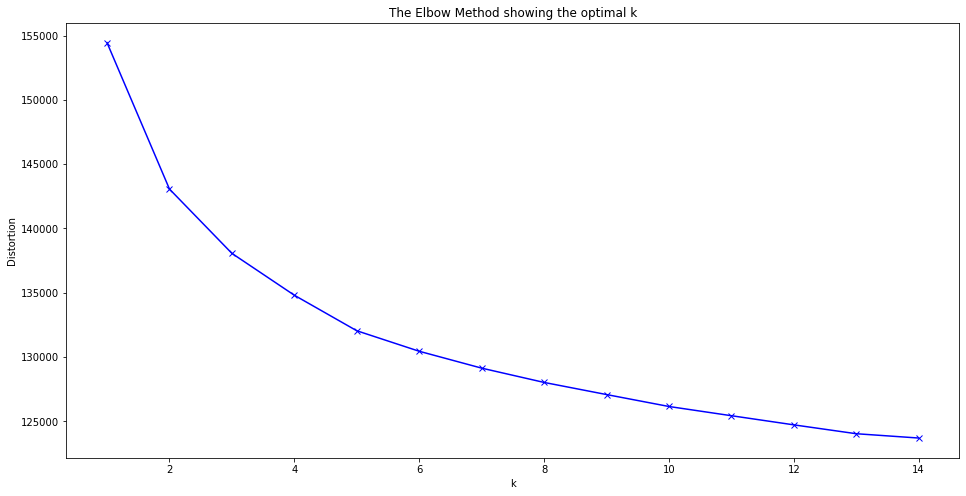

In [14]:
distortions = []

K = range(1, 15)

for k in K:
    km = KMeans(n_clusters=k)
    km.fit(cmpnts)
    distortions.append(km.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [30]:
km = KMeans(n_clusters=5, random_state=42)

km.fit_transform(cmpnts)

array([[12.05848882, 12.12072965, 15.77805825, 12.61999006, 11.83252558],
       [ 9.80834174,  8.7196409 , 13.51210334,  9.1594844 , 10.46768648],
       [10.54176757, 12.09541096, 16.84649353, 10.24690768, 12.29988873],
       ...,
       [10.88641883,  9.55892823, 13.18714267, 11.4710216 , 10.25513086],
       [10.29044617, 11.31489593, 16.10991918, 10.09418659, 11.56063867],
       [10.6219706 , 10.63857242, 13.86541641, 11.25401294,  9.94672484]])

In [31]:
bg_df = GeoAccessor.from_featureclass(str(enrch_fc), fields=['IDField']).rename(columns={'IDField': 'id'}).set_index('id').spatial.set_geometry('SHAPE', inplace=False)
bg_df.insert(0, 'kmeans_cluster', km.labels_)

bg_df.head()

,kmeans_cluster,SHAPE
id,,
410710305021,4,"{""rings"": [[[-123.566017000063, 45.21638999908..."
410050237001,1,"{""rings"": [[[-122.616170999632, 45.26745799929..."
410050237002,3,"{""rings"": [[[-122.57048000011571, 45.237516999..."
410050237003,3,"{""rings"": [[[-122.5111050007072, 45.2601139996..."
410050237004,1,"{""rings"": [[[-122.5074989996634, 45.2300989998..."


In [32]:
arcpy.management.Dissolve(km_fc, out_feature_class=kmeans_fc, dissolve_field='kmeans_cluster')

'D:\\projects\\arcgis-demographic-clustering\\data\\interim\\interim.gdb\\block_group_kmeans_sklearn'